# Converting Invariant Mass Arrays to ROOT Histograms

This notebook explains how to convert `.npy` invariant mass arrays into ROOT TH1 histograms for use with the BumpNet pipeline.

## Overview

1. **Input**: `.npy` files containing invariant mass arrays (in MeV)
2. **Process**: Bin the masses with consistent 1 GeV binning
3. **Output**: ROOT file with TH1 histograms

## Why Consistent Binning?

- BumpNet expects consistent binning across all histograms
- Enables direct comparison between different arrays
- Empty bins are fine - they just represent "no data in this range"


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from pathlib import Path
from tqdm import tqdm

# Set up paths
inv_mass_path = "/storage/agrp/netalev/archive/second_real_run/inv_masses/"
bin_width = 1.0  # 1 GeV bin width


## Step 1: Understanding the Data

First, let's examine what we're working with - the invariant mass arrays.


In [4]:
# Load a sample array to understand the data structure
npy_files = [f for f in os.listdir(inv_mass_path) if f.endswith('.npy')]
print(f"Total number of .npy files: {len(npy_files)}")
print(f"\nFirst few files:")
for f in npy_files[:5]:
    print(f"  - {f}")

# Load one example
sample_file = npy_files[0]
sample_array = np.load(os.path.join(inv_mass_path, sample_file))

print(f"\nSample file: {sample_file}")
print(f"Array shape: {sample_array.shape}")
print(f"Array dtype: {sample_array.dtype}")
print(f"Total entries: {sample_array.size}")

# Convert to GeV for analysis
sample_array_gev = sample_array * 1e-3
print(f"\nMass range (MeV): [{np.min(sample_array):.2f}, {np.max(sample_array):.2f}]")
print(f"Mass range (GeV): [{np.min(sample_array_gev):.2f}, {np.max(sample_array_gev):.2f}]")


Total number of .npy files: 6883

First few files:
  - 2024r-pp_b93ffce519ca94aa_FS_1e_1m_3j_0p_IM_1e_3j_1m_0p.npy
  - 2024r-pp_2fa1727f5bcc7c6c_FS_1e_1m_3j_2p_IM_1e_3j_1m_2p.npy
  - 2024r-pp_88c76fb7c868a160_FS_2e_1m_2j_0p_IM_2e_2j_0m_0p.npy
  - 2024r-pp_52113b4510ced601_FS_1e_2m_2j_1p_IM_0e_2j_0m_1p.npy
  - 2024r-pp_65b09c998349109b_FS_1e_1m_3j_3p_IM_1e_3j_1m_3p.npy

Sample file: 2024r-pp_b93ffce519ca94aa_FS_1e_1m_3j_0p_IM_1e_3j_1m_0p.npy
Array shape: (1453788,)
Array dtype: float64
Total entries: 1453788

Mass range (MeV): [26719.88, 4211610.35]
Mass range (GeV): [26.72, 4211.61]


## Step 2: Finding Global Mass Range

To create consistent binning, we need to find the global min and max across ALL arrays.


In [5]:
# Scan all arrays to find global range
print("Scanning all arrays to find global mass range...")
all_mins = []
all_maxs = []

for im_array_npy in tqdm(npy_files, desc="Scanning"):
    try:
        im_array = np.load(os.path.join(inv_mass_path, im_array_npy))
        im_array_gev = im_array * 1e-3  # Convert MeV to GeV
        all_mins.append(np.min(im_array_gev))
        all_maxs.append(np.max(im_array_gev))
    except Exception as e:
        print(f"Error loading {im_array_npy}: {e}")

global_min = np.min(all_mins)
global_max = np.max(all_maxs)

print(f"\n{'='*60}")
print(f"Global Mass Range Analysis")
print(f"{'='*60}")
print(f"Global minimum: {global_min:.2f} GeV")
print(f"Global maximum: {global_max:.2f} GeV")
print(f"Range: {global_max - global_min:.2f} GeV")
print(f"\nMin values distribution:")
print(f"  Mean: {np.mean(all_mins):.2f} GeV")
print(f"  Std:  {np.std(all_mins):.2f} GeV")
print(f"\nMax values distribution:")
print(f"  Mean: {np.mean(all_maxs):.2f} GeV")
print(f"  Std:  {np.std(all_maxs):.2f} GeV")


Scanning all arrays to find global mass range...


Scanning:   5%|▌         | 350/6883 [00:13<04:10, 26.04it/s]


KeyboardInterrupt: 

## Step 3: Visualizing Mass Range Distribution

Let's visualize how the mass ranges are distributed across different arrays.


In [ ]:
# Visualize the distribution of min and max values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Min values distribution
axes[0].hist(all_mins, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(global_min, color='red', linestyle='--', linewidth=2, label=f'Global min: {global_min:.2f} GeV')
axes[0].set_xlabel('Minimum Mass (GeV)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Arrays', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Minimum Mass Values', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Max values distribution
axes[1].hist(all_maxs, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(global_max, color='red', linestyle='--', linewidth=2, label=f'Global max: {global_max:.2f} GeV')
axes[1].set_xlabel('Maximum Mass (GeV)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Arrays', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Maximum Mass Values', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 4: Creating Consistent Bin Edges

Now we create bin edges with 1 GeV spacing that covers the global range.


In [ ]:
# Calculate number of bins needed
nbins = math.ceil((global_max - global_min) / bin_width)
bin_edges = np.linspace(global_min, global_max, nbins + 1)

print(f"{'='*60}")
print(f"Consistent Binning Configuration")
print(f"{'='*60}")
print(f"Bin width: {bin_width} GeV")
print(f"Number of bins: {nbins}")
print(f"Bin edges range: [{bin_edges[0]:.2f}, {bin_edges[-1]:.2f}] GeV")
print(f"\nFirst 5 bin edges: {bin_edges[:5]}")
print(f"Last 5 bin edges: {bin_edges[-5:]}")
print(f"\nActual bin width (first bin): {bin_edges[1] - bin_edges[0]:.4f} GeV")
print(f"Actual bin width (last bin): {bin_edges[-1] - bin_edges[-2]:.4f} GeV")


## Step 5: Visualizing Binning Strategy

Let's see how different arrays will be binned with this consistent scheme.


NameError: name 'bin_edges' is not defined

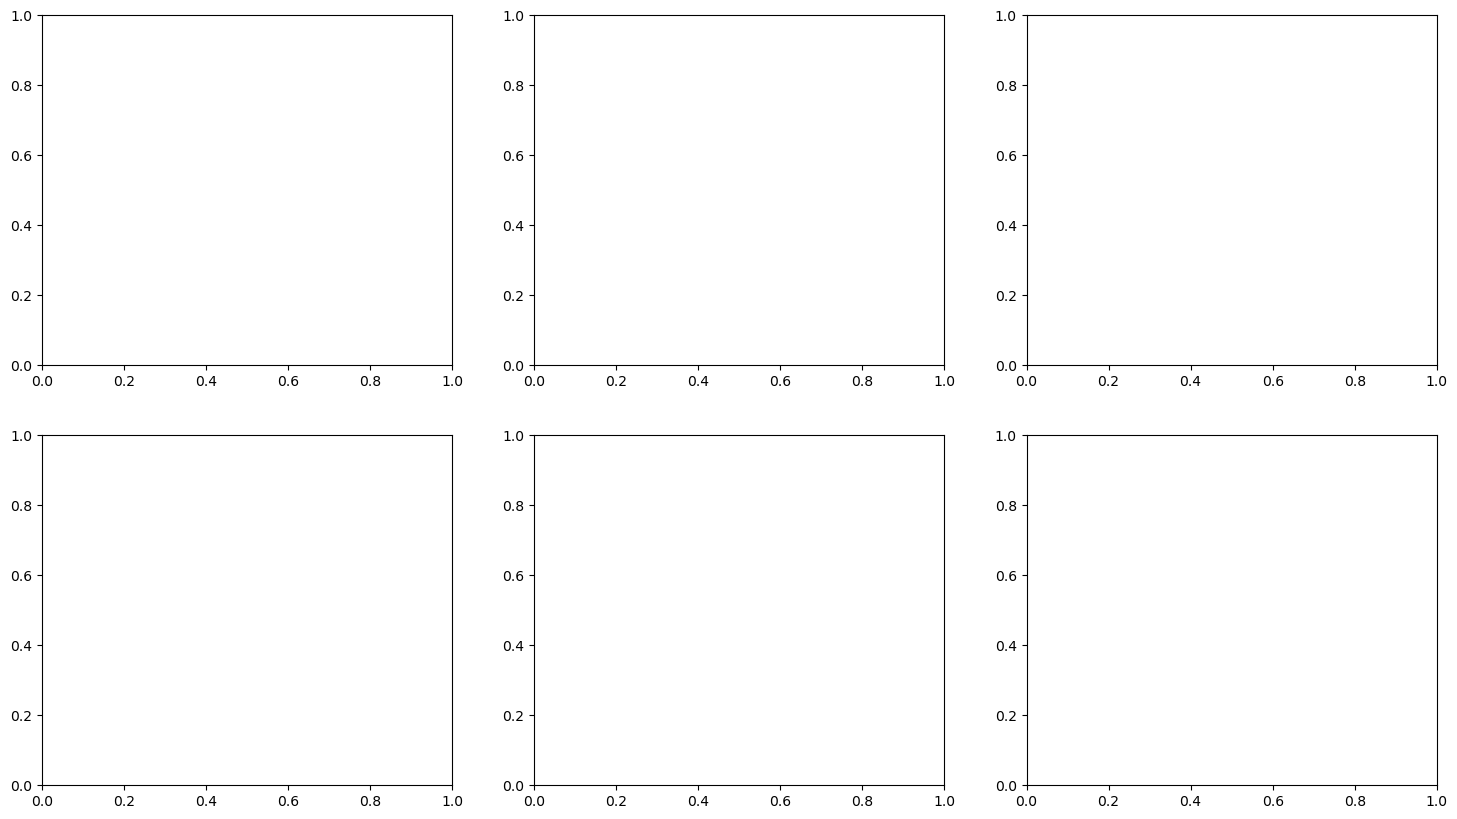

In [6]:
# Load a few sample arrays and show how they're binned
sample_files = npy_files[:6]  # Take 6 samples
n_samples = len(sample_files)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, sample_file in enumerate(sample_files):
    im_array = np.load(os.path.join(inv_mass_path, sample_file))
    im_array_gev = im_array * 1e-3
    
    # Create histogram with consistent binning
    hist_counts, _ = np.histogram(im_array_gev, bins=bin_edges)
    
    # Find which bins have data
    non_zero_bins = np.where(hist_counts > 0)[0]
    
    # Plot
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    axes[idx].bar(bin_centers[non_zero_bins], hist_counts[non_zero_bins], 
                 width=bin_width*0.8, alpha=0.7, color='steelblue', edgecolor='black')
    
    # Mark the array's actual range
    arr_min = np.min(im_array_gev)
    arr_max = np.max(im_array_gev)
    axes[idx].axvspan(arr_min, arr_max, alpha=0.2, color='red', label='Array range')
    
    # Formatting
    axes[idx].set_xlabel('Invariant Mass (GeV)', fontsize=10)
    axes[idx].set_ylabel('Events', fontsize=10)
    
    # Truncate filename for title
    title = sample_file.replace('.npy', '')[:50] + '...' if len(sample_file) > 50 else sample_file.replace('.npy', '')
    axes[idx].set_title(title, fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(fontsize=8)
    
    # Add stats
    stats_text = f"Entries: {len(im_array_gev):,}\nRange: [{arr_min:.1f}, {arr_max:.1f}] GeV"
    axes[idx].text(0.98, 0.98, stats_text, transform=axes[idx].transAxes,
                  fontsize=8, verticalalignment='top', horizontalalignment='right',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.suptitle(f'Sample Arrays with Consistent {bin_width} GeV Binning', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Step 6: Understanding Empty Bins

Let's visualize why empty bins are fine - they just represent regions with no data.


In [7]:
# Show an example with empty bins
example_file = sample_files[0]
im_array = np.load(os.path.join(inv_mass_path, example_file))
im_array_gev = im_array * 1e-3

# Create histogram
hist_counts, _ = np.histogram(im_array_gev, bins=bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Find empty and filled bins
empty_bins = np.where(hist_counts == 0)[0]
filled_bins = np.where(hist_counts > 0)[0]

fig, ax = plt.subplots(figsize=(14, 6))

# Plot filled bins
ax.bar(bin_centers[filled_bins], hist_counts[filled_bins], 
       width=bin_width*0.8, alpha=0.7, color='steelblue', 
       edgecolor='black', label='Filled bins (data)')

# Mark empty bins (very small bars to show they exist)
if len(empty_bins) > 0:
    ax.bar(bin_centers[empty_bins], [0.1]*len(empty_bins), 
           width=bin_width*0.8, alpha=0.3, color='lightgray', 
           edgecolor='gray', label='Empty bins (no data)')

# Mark array range
arr_min = np.min(im_array_gev)
arr_max = np.max(im_array_gev)
ax.axvspan(arr_min, arr_max, alpha=0.15, color='red', label='Array mass range')

ax.set_xlabel('Invariant Mass (GeV)', fontsize=12, fontweight='bold')
ax.set_ylabel('Events', fontsize=12, fontweight='bold')
ax.set_title(f'Example: {example_file}\nShowing Filled and Empty Bins with Consistent Binning', 
             fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Add statistics
stats_text = (
    f"Total bins: {len(bin_edges)-1}\n"
    f"Filled bins: {len(filled_bins)} ({100*len(filled_bins)/(len(bin_edges)-1):.1f}%)\n"
    f"Empty bins: {len(empty_bins)} ({100*len(empty_bins)/(len(bin_edges)-1):.1f}%)\n"
    f"Array range: [{arr_min:.2f}, {arr_max:.2f}] GeV"
)
ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='top', horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Empty Bins Explanation")
print(f"{'='*60}")
print(f"Empty bins are perfectly fine!")
print(f"- They represent 'no data in this mass range'")
print(f"- ROOT handles them correctly")
print(f"- BumpNet processes them without issues")
print(f"- They enable consistent comparison across arrays")


NameError: name 'bin_edges' is not defined

In [9]:
# Preview of ROOT conversion (commented out if ROOT not available)
try:
    print("importing ROOT")
    import ROOT
    print("Imported")
    # Create a sample ROOT histogram
    sample_file = sample_files[0]
    print(sample_file)
    im_array = np.load(os.path.join(inv_mass_path, sample_file))
    im_array_gev = im_array * 1e-3
    
    # Create ROOT histogram
    hist_name = f"ROI_{Path(sample_file).stem}"
    hist = ROOT.TH1F(hist_name, hist_name, len(bin_edges)-1, bin_edges)
    
    # Fill histogram
    for mass in im_array_gev:
        hist.Fill(mass)
    
    # Set errors
    for i in range(1, len(bin_edges)):
        content = hist.GetBinContent(i)
        hist.SetBinError(i, np.sqrt(content) if content > 0 else 0)
    
    print(f"\n{'='*60}")
    print(f"ROOT Histogram Created Successfully!")
    print(f"{'='*60}")
    print(f"Histogram name: {hist_name}")
    print(f"Number of bins: {hist.GetNbinsX()}")
    print(f"Total entries: {hist.GetEntries():.0f}")
    print(f"Underflow: {hist.GetBinContent(0)}")
    print(f"Overflow: {hist.GetBinContent(hist.GetNbinsX()+1)}")
    
except ImportError:
    print("ROOT not available in this environment.")
    print("The conversion script will handle ROOT creation.")
except Exception as e:
    print(f"ROOT test failed: {e}")


: 

## Summary

### Key Points:

1. **Consistent Binning**: All arrays use the same bin edges (1 GeV spacing)
2. **Global Range**: Based on min/max across all arrays
3. **Empty Bins**: Perfectly fine - they represent "no data" regions
4. **ROOT Format**: TH1 histograms with consistent structure

### Next Steps:

Run the conversion script to create the ROOT file:
```bash
python convert_npy_to_root.py --input_dir /storage/agrp/netalev/data/inv_masses/ --output_file rebinned.root --bin_width 1.0
```
